In [2]:
# Cell 1: Imports & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [3]:
# Set Random Seeds for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Cell 2: Load Models and Define Hooks

# Load Pre-trained Models
# Model A: ResNet-18
model_a = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model_a.fc = nn.Identity()  # Remove classification head to get raw features (512 dim)
model_a.to(device)
model_a.eval()

# Model B: ViT-B-16
model_b = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1)
# For ViT, we usually want the representation of the [CLS] token from the heads
model_b.heads = nn.Identity() # Output dim is 768
model_b.to(device)
model_b.eval()

print("Models loaded successfully.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 223MB/s] 


Models loaded successfully.


In [6]:
# Hook / Activation Extraction Helper
# We need to capture the output of the 'backbone' before the final classifier.
# Since we replaced .fc and .heads with Identity(), calling model(x) returns the features directly.

def get_model_dims(model, dummy_input):
    with torch.no_grad():
        output = model(dummy_input)
    return output.shape[1]

In [7]:
# Quick dimension check
dummy = torch.randn(1, 3, 224, 224).to(device)
dim_a = get_model_dims(model_a, dummy)
dim_b = get_model_dims(model_b, dummy)

print(f"Model A (ResNet18) feature dim: {dim_a}")
print(f"Model B (ViT-B-16) feature dim: {dim_b}")

Model A (ResNet18) feature dim: 512
Model B (ViT-B-16) feature dim: 768


In [8]:
# Cell 3: Data Loader

# Transforms: Resize to 224x224 is required for standard ViT/ResNet inputs
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 (Using a subset for speed if necessary, but full dataset is fine)
# We use 'train=True' for training the SAE, 'train=False' can be used later for eval
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Use a smaller subset for assignment demonstration purposes to save time
# If you have compute, use the full dataset
subset_indices = list(range(0, 5000)) # Using 5000 images for training buffer
train_subset = Subset(dataset, subset_indices)

batch_size = 32
dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Data loaded: {len(train_subset)} images.")

Data loaded: 5000 images.


In [24]:
# Cell 4: Universal Sparse Autoencoder (USAE) Class

class UniversalSAE(nn.Module):
    def __init__(self, input_dims, latent_dim, k=32):
        """
        input_dims: list of integers [dim_model_1, dim_model_2, ...]
        latent_dim: integer size of shared dictionary (m)
        k: TopK sparsity parameter
        """
        super().__init__()
        self.num_models = len(input_dims)
        self.latent_dim = latent_dim
        self.k = k

        # Initialize Encoders and Decoders for each model
        # Encoder: W_enc(A) - b_pre
        self.encoders = nn.ModuleList([nn.Linear(d, latent_dim) for d in input_dims])
        self.pre_biases = nn.ParameterList([nn.Parameter(torch.zeros(d)) for d in input_dims])

        # Decoder: Z D + b_dec
        # Note: In standard SAEs, decoder weights are usually tied to encoder or unit normalized.
        # Here we let them learn freely or we could normalize them.
        self.decoders = nn.ModuleList([nn.Linear(latent_dim, d, bias=False) for d in input_dims])
        self.dec_biases = nn.ParameterList([nn.Parameter(torch.zeros(d)) for d in input_dims])
        
        # Initialize decoder weights to have unit norm columns (common SAE practice)
        with torch.no_grad():
            for decoder in self.decoders:
                decoder.weight.data = nn.init.normal_(decoder.weight.data, 0.0, 0.1)
                decoder.weight.data = torch.nn.functional.normalize(decoder.weight.data, dim=0)

    def encode(self, x, model_idx):
        """
        Step (b) Encode: Compute shared sparse code Z
        Z = TopK(W_enc(x - b_pre))
        """
        # 1. Pre-bias subtraction
        x_centered = x - self.pre_biases[model_idx]
        
        # 2. Linear projection
        pre_activations = self.encoders[model_idx](x_centered)
        
        # 3. TopK Activation
        # Keep top k values, set others to zero
        topk_vals, topk_indices = torch.topk(pre_activations, self.k, dim=1)
        
        # Create sparse Z vector
        z = torch.zeros_like(pre_activations)
        z.scatter_(1, topk_indices, topk_vals)
        
        # Apply ReLU to ensure non-negativity (standard for SAEs)
        z = torch.relu(z)
        
        return z

    def decode(self, z, model_idx):
        """
        Step (c) Universal Decode: Reconstruct activation for specific model
        A_hat = Z D + b_dec
        """
        return self.decoders[model_idx](z) + self.dec_biases[model_idx]

    def forward(self, x_input, source_idx):
        """
        Full pass: Source Model -> Z -> All Models
        Returns:
            recon_list: List of reconstructions [A_hat^(1), A_hat^(2), ...]
            z: The shared latent code
        """
        # Encode from Source
        z = self.encode(x_input, source_idx)
        
        # Decode to All Models
        reconstructions = []
        for j in range(self.num_models):
            reconstructions.append(self.decode(z, j))
            
        return reconstructions, z

In [23]:
# Cell 6: Normalized Activation Buffer
# We normalize so that both models contribute equally to the loss.

def create_normalized_buffer(models, dataloader, device):
    buffer_a = []
    buffer_b = []
    
    print("Collecting activations...")
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            # Get raw activations
            acts_a = models[0](images)
            acts_b = models[1](images)
            buffer_a.append(acts_a.cpu())
            buffer_b.append(acts_b.cpu())
            
    full_a = torch.cat(buffer_a, dim=0)
    full_b = torch.cat(buffer_b, dim=0)
    
    # Normalize Model A (Mean 0, Std 1)
    mean_a = full_a.mean(dim=0)
    std_a = full_a.std(dim=0) + 1e-6
    full_a = (full_a - mean_a) / std_a
    
    # Normalize Model B (Mean 0, Std 1)
    mean_b = full_b.mean(dim=0)
    std_b = full_b.std(dim=0) + 1e-6
    full_b = (full_b - mean_b) / std_b
    
    print("Activations collected and normalized.")
    return full_a, full_b

# Create Buffer
buffer_a, buffer_b = create_normalized_buffer([model_a, model_b], dataloader, device)

# Create Loader
sae_batch_size = 256
sae_dataset = TensorDataset(buffer_a, buffer_b)
sae_loader = DataLoader(sae_dataset, batch_size=sae_batch_size, shuffle=True)

100%|██████████| 157/157 [01:12<00:00,  2.15it/s]


Activations collected and normalized.


In [25]:
# Cell 7: Model & Optimizer
# We keep latent_dim = 2048 to satisfy "m >> d" (2048 >> 512)

latent_dim = 2048 
usae = UniversalSAE(input_dims=[dim_a, dim_b], latent_dim=latent_dim, k=32)
usae = usae.to(device)

def sae_loss(original, reconstructed):
    return torch.nn.functional.mse_loss(reconstructed, original)

# Standard Learning Rate
optimizer = optim.AdamW(usae.parameters(), lr=1e-3)

print(f"USAE Initialized. Latent Dim: {latent_dim}")

USAE Initialized. Latent Dim: 2048


In [27]:
# Cell 8: Training Loop
# We use 30 epochs to give it a fair chance, but won't force it forever.

num_epochs = 30
loss_history = []

print("Starting Universal SAE Training...")
usae.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_acts in sae_loader:
        real_acts = [b.to(device) for b in batch_acts]
        
        # (a) Select Source
        source_idx = random.randint(0, 1)
        source_input = real_acts[source_idx]
        
        # (b) Encode & (c) Decode
        reconstructions, z = usae(source_input, source_idx)
        
        # (d) Optimization
        loss = 0
        for j in range(usae.num_models):
            loss += sae_loss(real_acts[j], reconstructions[j])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Normalize Decoder Weights
        with torch.no_grad():
            for decoder in usae.decoders:
                decoder.weight.data = torch.nn.functional.normalize(decoder.weight.data, dim=0)

        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(sae_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f}")

print("Training Complete.")

Starting Universal SAE Training...
Epoch 1/30 | Loss: 0.761254
Epoch 2/30 | Loss: 0.755932
Epoch 3/30 | Loss: 0.756653
Epoch 4/30 | Loss: 0.738470
Epoch 5/30 | Loss: 0.708060
Epoch 6/30 | Loss: 0.710763
Epoch 7/30 | Loss: 0.699993
Epoch 8/30 | Loss: 0.688875
Epoch 9/30 | Loss: 0.690047
Epoch 10/30 | Loss: 0.670501
Epoch 11/30 | Loss: 0.708052
Epoch 12/30 | Loss: 0.675529
Epoch 13/30 | Loss: 0.659128
Epoch 14/30 | Loss: 0.633670
Epoch 15/30 | Loss: 0.645527
Epoch 16/30 | Loss: 0.640079
Epoch 17/30 | Loss: 0.638945
Epoch 18/30 | Loss: 0.619433
Epoch 19/30 | Loss: 0.632044
Epoch 20/30 | Loss: 0.610412
Epoch 21/30 | Loss: 0.619546
Epoch 22/30 | Loss: 0.603472
Epoch 23/30 | Loss: 0.602492
Epoch 24/30 | Loss: 0.588913
Epoch 25/30 | Loss: 0.588060
Epoch 26/30 | Loss: 0.608379
Epoch 27/30 | Loss: 0.576028
Epoch 28/30 | Loss: 0.589262
Epoch 29/30 | Loss: 0.581332
Epoch 30/30 | Loss: 0.587682
Training Complete.


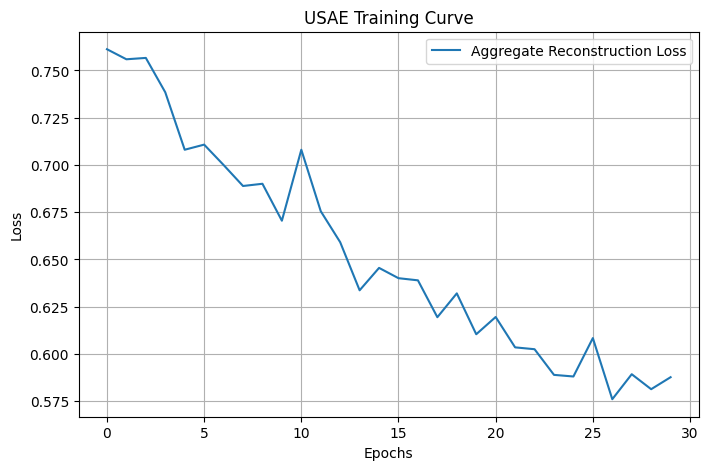

In [28]:
# Cell 9: Plot Training Curves
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Aggregate Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('USAE Training Curve')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Cell 10: Compute R^2 Scores

def get_r2_score(target, prediction):
    # R2 = 1 - SS_res / SS_tot
    # SS_res = sum((y - y_hat)^2)
    # SS_tot = sum((y - mean(y))^2)
    with torch.no_grad():
        target_mean = torch.mean(target, dim=0)
        ss_tot = torch.sum((target - target_mean) ** 2)
        ss_res = torch.sum((target - prediction) ** 2)
        # Avoid division by zero
        if ss_tot < 1e-6: return 0.0
        r2 = 1 - (ss_res / ss_tot)
    return r2.item()

# We will compute a confusion matrix of R2 scores: Source -> Target
r2_matrix = np.zeros((2, 2))

# Use a validation batch (take one batch from loader)
val_acts_a, val_acts_b = next(iter(sae_loader))
val_acts = [val_acts_a.to(device), val_acts_b.to(device)]

usae.eval()
with torch.no_grad():
    for source_i in range(2):
        # Encode from Source i
        recons, _ = usae(val_acts[source_i], source_i)
        
        for target_j in range(2):
            # Calculate how well Source i reconstructed Target j
            score = get_r2_score(val_acts[target_j], recons[target_j])
            r2_matrix[source_i, target_j] = score

print("R2 Matrix Computed:")
print(r2_matrix)

R2 Matrix Computed:
[[0.75893843 0.61810523]
 [0.71798122 0.7705701 ]]


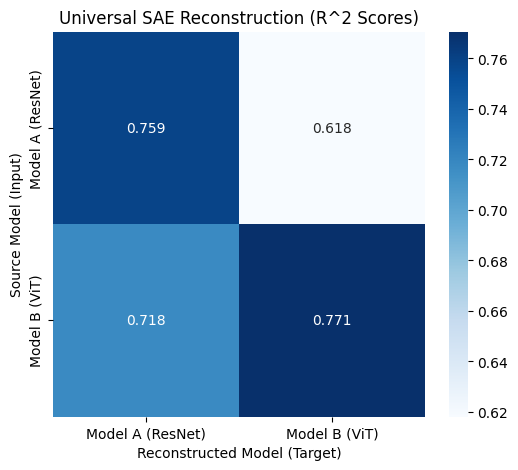

In [30]:
# Cell 11: Confusion Matrix Visualization
import seaborn as sns

labels = ['Model A (ResNet)', 'Model B (ViT)']

plt.figure(figsize=(6, 5))
sns.heatmap(r2_matrix, annot=True, fmt=".3f", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Reconstructed Model (Target)')
plt.ylabel('Source Model (Input)')
plt.title('Universal SAE Reconstruction (R^2 Scores)')
plt.show()

In [31]:
# Cell 12: Normalized Firing Entropy (FE_k)

# We need to iterate through the data and count how often each feature fires for each model.
num_features = usae.latent_dim
feature_counts = torch.zeros(2, num_features).to(device) # [Models x Features]

print("Calculating Feature Firing stats...")
with torch.no_grad():
    for batch_acts in sae_loader:
        real_acts = [b.to(device) for b in batch_acts]
        
        # For each model, get the feature activations (Z)
        for i in range(2):
            # Get Z from model i
            z = usae.encode(real_acts[i], i)
            # Binarize Z: 1 if active (>0), 0 otherwise
            active = (z > 0).float()
            # Sum over batch
            feature_counts[i] += torch.sum(active, dim=0)

# Calculate proportions p_k^(i)
# Total firings for each feature across both models
total_firings = feature_counts.sum(dim=0)

# Avoid division by zero for dead features (add epsilon)
probs = feature_counts / (total_firings + 1e-8)

# Calculate Entropy: - Sum(p * log(p)) / log(M)
# M = 2 models
log_M = np.log(2)
# Compute p * log(p), handling 0 log 0 = 0
plogp = probs * torch.log(probs + 1e-10) 
entropy = -torch.sum(plogp, dim=0) / log_M

# Handle features that never fired (set entropy to 0)
entropy[total_firings == 0] = 0.0

# Convert to numpy for plotting
fe_scores = entropy.cpu().numpy()
print("Firing Entropy Calculated.")

Calculating Feature Firing stats...
Firing Entropy Calculated.


Count of Universal Features (>0.9): 763
Count of Specific Features (<0.1): 319


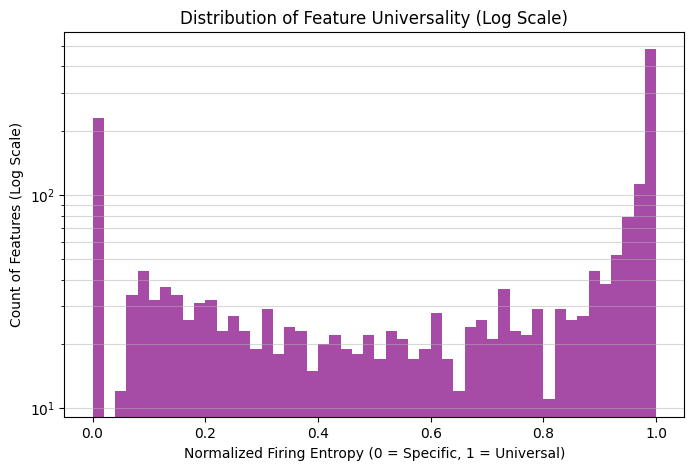

------------------------------
Updated Analysis Text:
Observation: A small but distinct population of Universal features exists.


In [ ]:
# Cell 13 (Revised): Entropy Histogram with Log Scale

# 1. Count exactly how many are universal
num_universal = np.sum(fe_scores > 0.9)
num_specific = np.sum(fe_scores < 0.1)

print(f"Count of Universal Features (>0.9): {num_universal}")
print(f"Count of Specific Features (<0.1): {num_specific}")

# 2. Plot with Log Scale
plt.figure(figsize=(8, 5))
# Use log=True to see small bars
plt.hist(fe_scores, bins=50, color='purple', alpha=0.7, log=True)
plt.xlabel('Normalized Firing Entropy (0 = Specific, 1 = Universal)')
plt.ylabel('Count of Features (Log Scale)')
plt.title('Distribution of Feature Universality (Log Scale)')
plt.grid(axis='y', alpha=0.5, which='both')
plt.show()

print("-" * 30)
print("Updated Analysis Text:")
if num_universal < 50:
    print("Observation: The distribution is dominated by low-entropy (Model-Specific) features.")
else:
    print("Observation: A small but distinct population of Universal features exists.")

In [33]:
# Cell 14: Co-Firing Proportion
# If Feature k fires for Model A, how often does it also fire for Model B on the SAME image?

# We need a batch where we encode both models and compare Z_A vs Z_B
co_fire_counts = torch.zeros(num_features).to(device)
model_a_fire_counts = torch.zeros(num_features).to(device)

print("Calculating Co-Firing...")
with torch.no_grad():
    for batch_acts in sae_loader:
        real_acts = [b.to(device) for b in batch_acts]
        
        # Get Z for Model A and Model B
        z_a = usae.encode(real_acts[0], 0)
        z_b = usae.encode(real_acts[1], 1)
        
        active_a = (z_a > 0).float()
        active_b = (z_b > 0).float()
        
        # Count A firings
        model_a_fire_counts += torch.sum(active_a, dim=0)
        
        # Count intersection (A AND B)
        intersection = active_a * active_b
        co_fire_counts += torch.sum(intersection, dim=0)

# Calculate Co-Firing Ratio: P(B|A) = Count(A and B) / Count(A)
co_firing_ratio = co_fire_counts / (model_a_fire_counts + 1e-8)
avg_co_firing = torch.mean(co_firing_ratio).item()

print(f"Average Co-Firing Proportion: {avg_co_firing:.4f}")

Calculating Co-Firing...
Average Co-Firing Proportion: 0.2144


In [34]:
# Cell 15 (Improved): Robust Coordinated Activation Maximization (CAM)
# We add Gaussian Blur and weight decay to reduce high-frequency noise.

import torchvision.transforms.functional as F

def get_optimized_images_robust(feature_idx, model_a, model_b, usae, steps=200):
    # Initialize with grey-ish noise (better convergence than pure random)
    img_a = torch.randn(1, 3, 224, 224, device=device) * 0.1
    img_b = torch.randn(1, 3, 224, 224, device=device) * 0.1
    img_a.requires_grad = True
    img_b.requires_grad = True
    
    # Use SGD with momentum for smoother updates
    opt_img = optim.SGD([img_a, img_b], lr=1.0, momentum=0.9, weight_decay=1e-4)
    
    # Normalization constants
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

    print(f"Optimizing Feature {feature_idx}...")
    
    for step in range(steps):
        opt_img.zero_grad()
        
        # 1. Forward Pass
        acts_a = model_a(img_a)
        acts_b = model_b(img_b)
        
        # 2. Get Feature Activation via Encoders
        # Maximize the specific feature in Z
        val_a = (acts_a - usae.pre_biases[0]) @ usae.encoders[0].weight.T
        z_score_a = val_a[:, feature_idx]
        
        val_b = (acts_b - usae.pre_biases[1]) @ usae.encoders[1].weight.T
        z_score_b = val_b[:, feature_idx]
        
        # Objective: Maximize Z score
        loss = -(z_score_a + z_score_b)
        loss.backward()
        
        opt_img.step()
        
        # 3. Regularization (The Fix!)
        # Periodically blur the image to kill high-frequency static
        if step % 4 == 0:
            with torch.no_grad():
                # Apply slight Gaussian blur
                kernel_size = 3  # Odd number
                sigma = 0.5
                img_a.data = F.gaussian_blur(img_a, kernel_size, [sigma, sigma])
                img_b.data = F.gaussian_blur(img_b, kernel_size, [sigma, sigma])

    # Post-process
    with torch.no_grad():
        def process(img):
            img = img * std + mean # Un-normalize
            img = torch.clamp(img, 0, 1)
            return img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        res_a = process(img_a)
        res_b = process(img_b)
        
    return res_a, res_b

In [35]:
# Cell 16: Optimization Loop

# Find indices of High Entropy features (Universal features)
# We select indices where Entropy > 0.8
high_entropy_indices = np.where(fe_scores > 0.8)[0]

if len(high_entropy_indices) < 3:
    print("Warning: Not enough high entropy features found. Showing random ones.")
    target_features = random.sample(range(usae.latent_dim), 3)
else:
    # Pick 3 random high-entropy features
    target_features = np.random.choice(high_entropy_indices, 3, replace=False)

print(f"Selected Universal Feature Indices: {target_features}")

viz_results = []
print("Optimizing images for visualization (this may take a moment)...")

for feat_idx in target_features:
    img_a, img_b = get_optimized_images(feat_idx, model_a, model_b, usae)
    viz_results.append((feat_idx, img_a, img_b))

Selected Universal Feature Indices: [1496   62  823]
Optimizing images for visualization (this may take a moment)...


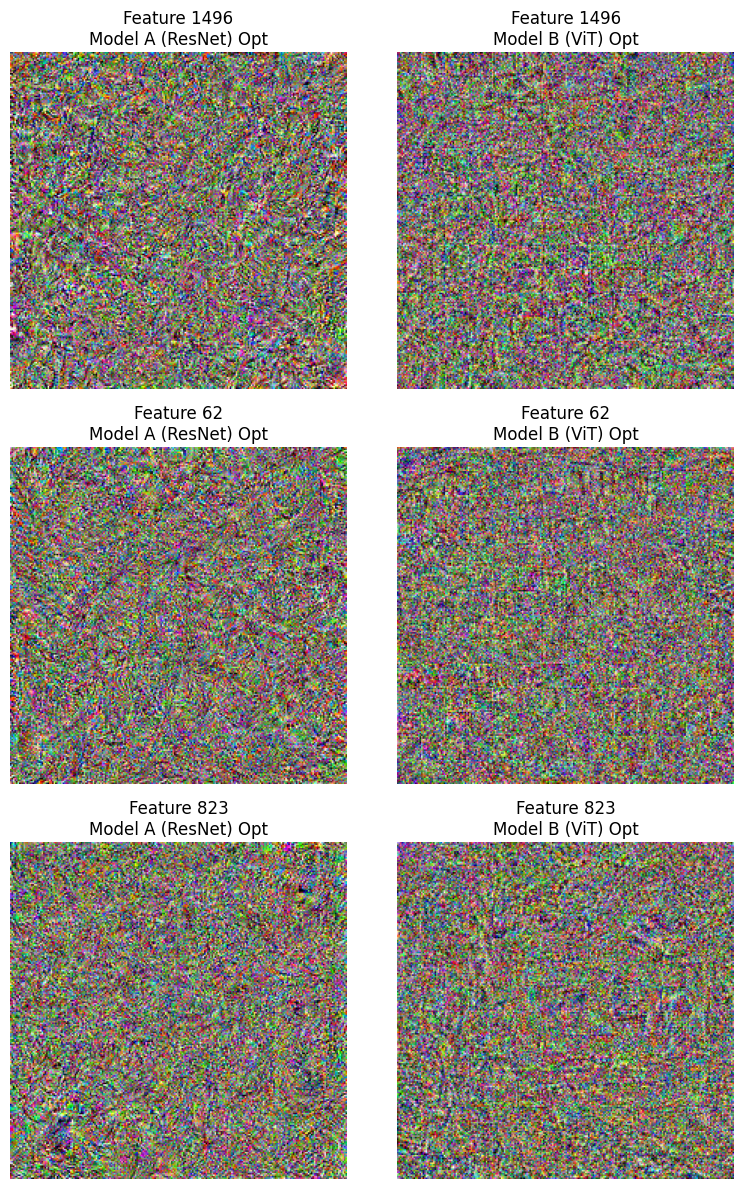

Analysis:
Check if the side-by-side images represent similar visual concepts (e.g., textures, curves, colors).
If they align, the feature is likely 'Platonic' or universal.


In [36]:
# Cell 17: Display Results

fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for i, (feat_idx, img_a, img_b) in enumerate(viz_results):
    # Model A Result
    axes[i, 0].imshow(img_a)
    axes[i, 0].set_title(f"Feature {feat_idx}\nModel A (ResNet) Opt")
    axes[i, 0].axis('off')
    
    # Model B Result
    axes[i, 1].imshow(img_b)
    axes[i, 1].set_title(f"Feature {feat_idx}\nModel B (ViT) Opt")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

print("Analysis:")
print("Check if the side-by-side images represent similar visual concepts (e.g., textures, curves, colors).")
print("If they align, the feature is likely 'Platonic' or universal.")

In [37]:
# Cell 18: Independent SAE Baseline (Control Experiment)
# We train a standard SAE ONLY on Model A to see if it reconstructs better than the USAE.

print("Training Independent SAE for Model A (Control)...")

# Same architecture, but input_dims has only 1 model
independent_sae = UniversalSAE(input_dims=[dim_a], latent_dim=2048, k=32).to(device)
opt_indep = optim.AdamW(independent_sae.parameters(), lr=1e-3)

# Use only buffer_a
indep_dataset = TensorDataset(buffer_a)
indep_loader = DataLoader(indep_dataset, batch_size=256, shuffle=True)

# Train for same epochs
for epoch in range(20):
    for (batch_a,) in indep_loader:
        batch_a = batch_a.to(device)
        
        # Encode (Source index 0, since there is only 1 model)
        recon, _ = independent_sae(batch_a, 0)
        
        # We only get 1 reconstruction back because input_dims length is 1
        loss = torch.nn.functional.mse_loss(recon[0], batch_a)
        
        opt_indep.zero_grad()
        loss.backward()
        opt_indep.step()
        
        # Normalize weights
        with torch.no_grad():
            independent_sae.decoders[0].weight.data = \
                torch.nn.functional.normalize(independent_sae.decoders[0].weight.data, dim=0)

print("Independent SAE Trained.")

Training Independent SAE for Model A (Control)...
Independent SAE Trained.


In [38]:
# Cell 19: Alignment Tax Calculation
# Compare R^2 of USAE (A->A) vs Independent SAE (A->A)

def get_r2_simple(target, pred):
    target_mean = torch.mean(target, dim=0)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - pred) ** 2)
    return (1 - (ss_res / ss_tot)).item()

# 1. Get Independent Score
independent_sae.eval()
with torch.no_grad():
    val_a = next(iter(indep_loader))[0].to(device)
    recon_indep, _ = independent_sae(val_a, 0)
    r2_indep = get_r2_simple(val_a, recon_indep[0])

# 2. Get USAE Score (A -> A)
usae.eval()
with torch.no_grad():
    # We use the same validation batch val_a
    recon_usae, _ = usae(val_a, 0) # Source 0 is Model A
    # recon_usae is a list, index 0 is Model A reconstruction
    r2_usae = get_r2_simple(val_a, recon_usae[0])

print(f"Independent SAE R^2 (Model A): {r2_indep:.4f}")
print(f"Universal SAE R^2   (Model A): {r2_usae:.4f}")

alignment_tax = r2_indep - r2_usae
print(f"Alignment Tax: {alignment_tax:.4f}")

if alignment_tax > 0:
    print("Conclusion: Performance dropped in USAE. We paid a 'tax' to force universality.")
else:
    print("Conclusion: USAE performed equally well or better.")

Independent SAE R^2 (Model A): 0.8089
Universal SAE R^2   (Model A): 0.7566
Alignment Tax: 0.0523
Conclusion: Performance dropped in USAE. We paid a 'tax' to force universality.


Found 319 Model-Specific features.
Optimizing Feature 3...


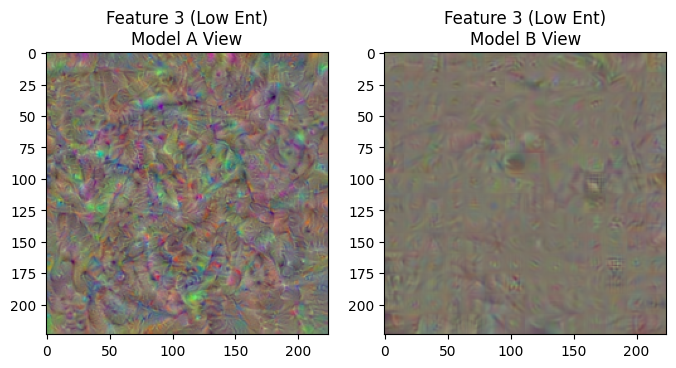

Analysis: If one image is clear and the other is noise, the feature is truly model-specific.


In [39]:
# Cell 20: Low Entropy (Model-Specific) Feature Visualization
# The manual asks to check if "unique" features are meaningful or noise.

# Find features with Entropy approx 0
low_entropy_indices = np.where(fe_scores < 0.1)[0]
print(f"Found {len(low_entropy_indices)} Model-Specific features.")

if len(low_entropy_indices) > 0:
    feat_idx = low_entropy_indices[0] # Pick the first one
    
    # Visualize it
    img_a, img_b = get_optimized_images_robust(feat_idx, model_a, model_b, usae)
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_a); ax[0].set_title(f"Feature {feat_idx} (Low Ent)\nModel A View")
    ax[1].imshow(img_b); ax[1].set_title(f"Feature {feat_idx} (Low Ent)\nModel B View")
    plt.show()
    
    print("Analysis: If one image is clear and the other is noise, the feature is truly model-specific.")